In [56]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin

In [84]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    key = 'decoded_pdfs.crosssession.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1,2])
        # print(pdf)
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [108]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r']
n_voxels = [0, 100]
natural_space = [False]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/280 [00:00<?, ?it/s]

/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.volume.denoise/sub-01/func/sub-01_ses-2_mask-NPCr_nvoxels-0_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.volume.denoise/sub-01/func/sub-01_ses-2_mask-NPCr_nvoxels-0_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.volume.denoise/sub-01/func/sub-01_ses-2_mask-NPC12r_nvoxels-0_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.volume.denoise/sub-01/func/sub-01_ses-2_mask-NPC12r_nvoxels-0_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.volume.denoise/sub-01/func/sub-01_ses-3_mask-NPCr_nvoxels-0_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.volume.denoise/sub-01/func/sub-01_ses-3_mask-NPCr_nvoxels-0_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.volume.denoise/sub-01/func/sub-01_ses-3_mask-NPC12r_nvoxels-0_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.crosssession.v

In [99]:
df = get_all_behavior(drop_no_responses=False)
pred = pd.concat(pred)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:66: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:41: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_69200/3024863706.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


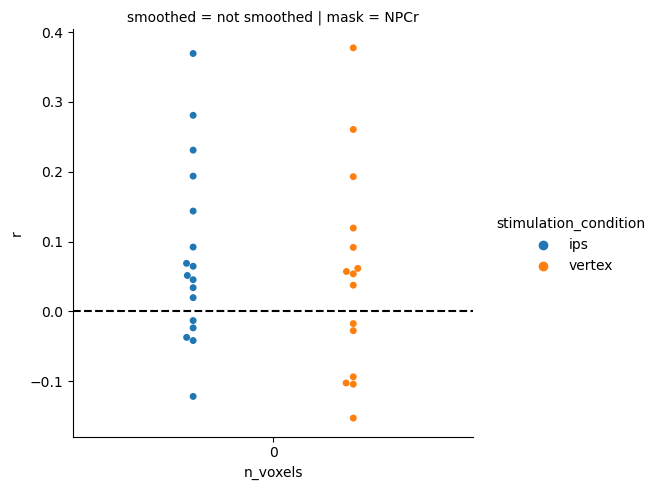

In [100]:
import seaborn as sns
g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

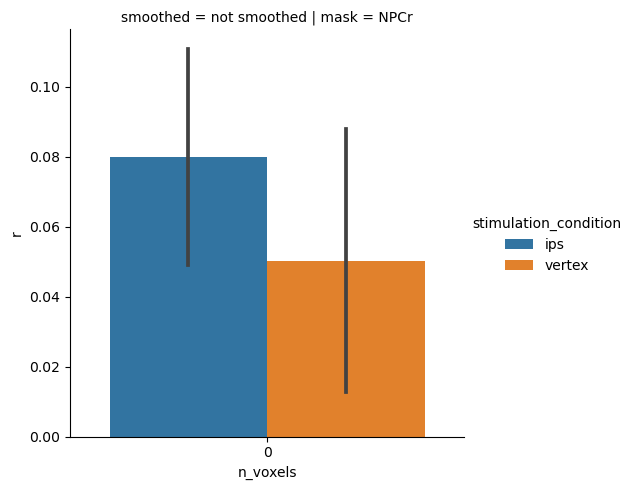

In [101]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, errorbar='se')

In [102]:
r2.groupby(['subject', 'stimulation_condition', 'n_voxels', 'mask']).size().groupby(['stimulation_condition', 'n_voxels', 'mask']).size()

stimulation_condition  n_voxels  mask
ips                    0         NPCr    17
vertex                 0         NPCr    15
dtype: int64

In [103]:
pred['error'] = pred['E'] - pred['n1']

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_69200/2652208079.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().reset_index(), x='n_voxels', col='risky_first', hue='stimulation_condition', y='error', kind='point', errorbar='se',


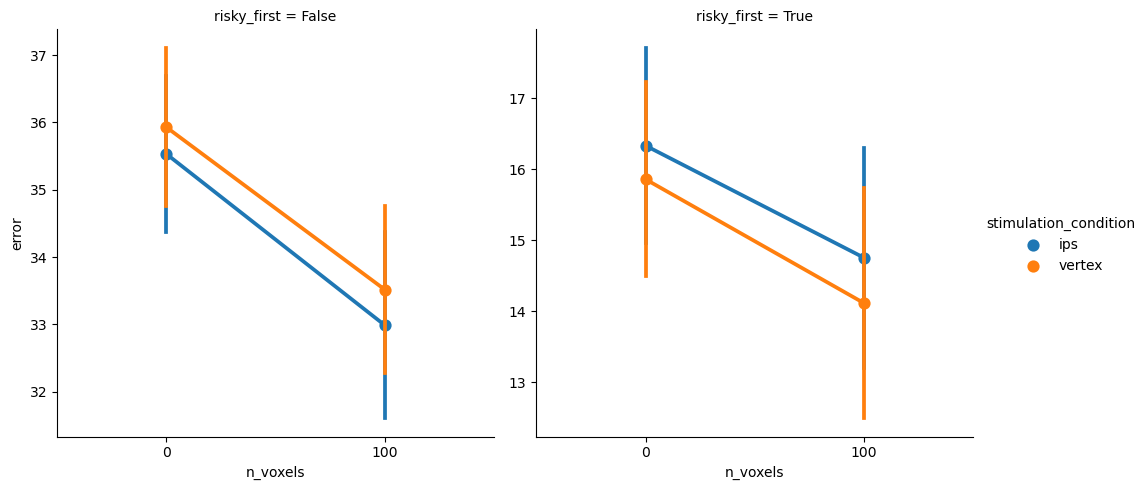

In [77]:
sns.catplot(data=pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().reset_index(), x='n_voxels', col='risky_first', hue='stimulation_condition', y='error', kind='point', errorbar='se',
            sharey=False)

In [78]:
tmp = pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().xs(100, 0, 'n_voxels')


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_69200/3569611994.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().xs(100, 0, 'n_voxels')


ValueError: within must be a string, int or a list.

In [ ]:
pred.groupby(['subject', 'session', 'n_voxels']).size().groupby(['n_voxels', 'session']).size()

n_voxels  session
0         2          35
          3          35
100       2          35
          3          35
dtype: int64

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_69200/1664714461.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.groupby(['subject', 'stimulation_condition', 'n_voxels']).mean()


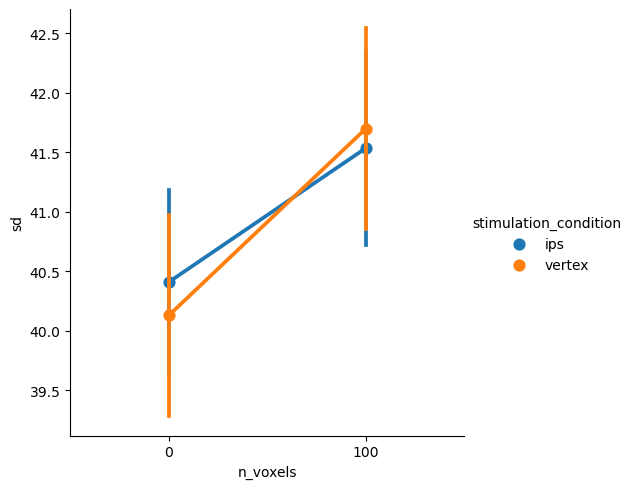

In [ ]:
tmp = pred.groupby(['subject', 'stimulation_condition', 'n_voxels']).mean()

sns.catplot(x='n_voxels', y='sd', hue='stimulation_condition', data=tmp.reset_index(), kind='point', errorbar='se')